In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
from alive_progress import alive_bar
import time

# Load the data
train_data = pd.read_parquet("data/train_data.parquet")
test_data = pd.read_parquet("data/test_data.parquet")

# Convert expiry to datetime if it's not already
if train_data["expiry"].dtype != "datetime64[ns]":
    train_data["expiry"] = pd.to_datetime(train_data["expiry"])

# Get the target expiry date
target_date = pd.Timestamp("2025-05-08").date()

In [93]:
data_path = "data"
output_path = "output/"
temp_path = "tmp/"

sample_submission = pd.read_csv(f"{data_path}/sample_submission.csv")
submission_cols = sample_submission.columns.tolist()

In [94]:
# Filter rows with the specified expiry date
expiry_filter = train_data['expiry'].dt.date == target_date
target_rows = train_data[expiry_filter]

# Get indices of rows to be used for validation (50% of the rows with target expiry)
validation_indices = target_rows.sample(frac=0.5, random_state=43).index

# Create validation set
val_data = train_data.loc[validation_indices].copy()

# Remove validation data from training set
train_data = train_data.drop(validation_indices)

# Print shapes to confirm
print(f"Original training data shape: {len(train_data) + len(val_data)}")
print(f"New training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Original training data shape: 178340
New training data shape: (138752, 97)
Validation data shape: (39588, 97)
Test data shape: (12065, 96)


In [95]:
test_data.columns

Index(['timestamp', 'underlying', 'call_iv_24000', 'call_iv_24100',
       'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500',
       'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900',
       'call_iv_25000', 'call_iv_25100', 'call_iv_25200', 'call_iv_25300',
       'call_iv_25400', 'call_iv_25500', 'call_iv_25600', 'call_iv_25700',
       'call_iv_25800', 'call_iv_25900', 'call_iv_26000', 'call_iv_26100',
       'call_iv_26200', 'call_iv_26300', 'call_iv_26400', 'call_iv_26500',
       'put_iv_23000', 'put_iv_23100', 'put_iv_23200', 'put_iv_23300',
       'put_iv_23400', 'put_iv_23500', 'put_iv_23600', 'put_iv_23700',
       'put_iv_23800', 'put_iv_23900', 'put_iv_24000', 'put_iv_24100',
       'put_iv_24200', 'put_iv_24300', 'put_iv_24400', 'put_iv_24500',
       'put_iv_24600', 'put_iv_24700', 'put_iv_24800', 'put_iv_24900',
       'put_iv_25000', 'put_iv_25100', 'put_iv_25200', 'put_iv_25300',
       'put_iv_25400', 'put_iv_25500', 'X0', 'X1', 'X2',

In [96]:
train_data.columns

Index(['timestamp', 'underlying', 'expiry', 'call_iv_23500', 'call_iv_23600',
       'call_iv_23700', 'call_iv_23800', 'call_iv_23900', 'call_iv_24000',
       'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400',
       'call_iv_24500', 'call_iv_24600', 'call_iv_24700', 'call_iv_24800',
       'call_iv_24900', 'call_iv_25000', 'call_iv_25100', 'call_iv_25200',
       'call_iv_25300', 'call_iv_25400', 'call_iv_25500', 'call_iv_25600',
       'call_iv_25700', 'call_iv_25800', 'call_iv_25900', 'call_iv_26000',
       'put_iv_22500', 'put_iv_22600', 'put_iv_22700', 'put_iv_22800',
       'put_iv_22900', 'put_iv_23000', 'put_iv_23100', 'put_iv_23200',
       'put_iv_23300', 'put_iv_23400', 'put_iv_23500', 'put_iv_23600',
       'put_iv_23700', 'put_iv_23800', 'put_iv_23900', 'put_iv_24000',
       'put_iv_24100', 'put_iv_24200', 'put_iv_24300', 'put_iv_24400',
       'put_iv_24500', 'put_iv_24600', 'put_iv_24700', 'put_iv_24800',
       'put_iv_24900', 'put_iv_25000', 'X0', '

In [97]:
pred_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"), val_data.columns.tolist()
    )
)
len(pred_cols)

52

## Setting 32 columns to nan randomly in each row

In [98]:
# Create a copy of val_data to avoid modifying the original
sample_val = val_data.copy()

# Get the call and put columns separately
call_cols = [col for col in pred_cols if col.startswith('call')]
put_cols = [col for col in pred_cols if col.startswith('put')]

# For each row, randomly select 16 call columns and 16 put columns to set to NaN
for idx in sample_val.index:
  # Randomly select 16 call columns for this row
  nan_call_cols = np.random.choice(call_cols, size=16, replace=False)
  
  # Randomly select 16 put columns for this row
  nan_put_cols = np.random.choice(put_cols, size=16, replace=False)
  
  # Set these columns to NaN for this row
  sample_val.loc[idx, nan_call_cols] = np.nan
  sample_val.loc[idx, nan_put_cols] = np.nan

# Create val_Y from the original validation data, containing only the target columns
val_Y = val_data[pred_cols]

In [99]:
sample_val

,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
158881,1746590742000000000,24433.0,2025-05-08,NaN,NaN,NaN,NaN,0.323607,NaN,0.256415,...,-0.022656,0.006262,2.553592e+06,-0.001931,2.372125,0.068108,-1.522534e+06,-3.048516e+06,1.254699e+06,-0.000000e+00
117518,1746176782000000000,24285.5,2025-05-08,NaN,NaN,NaN,0.178467,0.170073,0.161772,0.154975,...,0.003836,-0.004734,6.693594e+05,0.010055,1.315715,0.030237,5.235704e+04,-8.124241e+06,1.313372e+06,-1.000000e-06
155403,1746520665000000000,24387.5,2025-05-08,NaN,0.270770,0.245484,0.224076,NaN,NaN,NaN,...,0.001037,0.003309,2.847738e+06,0.008796,0.648142,0.041674,3.459928e+05,-2.764208e+07,2.203250e+06,0.000000e+00
159498,1746591359000000000,24384.6,2025-05-08,NaN,NaN,NaN,0.341066,0.309727,NaN,NaN,...,0.035097,-0.030470,-3.629051e+06,0.146150,-8.941554,1.278703,6.211531e+06,7.623811e+06,-5.587995e+05,3.208558e+06
106693,1746165957000000000,24329.3,2025-05-08,NaN,NaN,0.196625,NaN,NaN,0.173841,NaN,...,0.001900,0.002318,-1.051215e+06,0.026776,0.242156,0.025405,2.716713e+06,-3.698245e+06,-0.000000e+00,-0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150469,1746515731000000000,24393.6,2025-05-08,0.287421,NaN,NaN,0.224296,0.199508,0.174512,0.151060,...,-0.008578,-0.004349,7.608529e+05,0.022286,0.276633,-0.049681,-3.766206e+05,3.310812e+06,0.000000e+00,0.000000e+00
178012,1746609873000000000,24362.1,2025-05-08,0.424743,NaN,0.360815,0.329185,NaN,NaN,0.216435,...,0.006081,-0.001241,-5.956005e+06,-0.053984,-2.637237,0.118681,-7.248843e+05,-4.210857e+06,-3.790669e+06,0.000000e+00
114201,1746173465000000000,24415.4,2025-05-08,0.216450,0.207705,NaN,0.188346,NaN,0.169431,NaN,...,0.016044,0.013809,-1.940570e+05,-0.009913,1.074973,0.016054,-3.876233e+05,4.172262e+06,0.000000e+00,1.000000e-06
133136,1746431799000000000,24450.5,2025-05-08,NaN,NaN,0.223819,0.207044,NaN,0.172838,NaN,...,-0.008472,0.003098,3.785463e+05,0.001317,0.374664,0.009704,-6.879767e+06,-6.470817e+06,0.000000e+00,0.000000e+00


In [100]:
sample_val.shape

(39588, 97)

Fitting SVI models |████████████████████████████████████████| 39588/39588 [100%]|▏                                       | ▄▆█ 112/39588 [0%]|█▎                                      | ▄▆█ 1292/39588 [3%|█▍                                      | ▃▅▇ 1401/39588 [4%|██▍                                     | ▃▁▃ 2358/39588 [6%|███▎                                    | █▆▄ 3240/39588 [8%|███▋                                    | ▃▁▃ 3609/39588 [9%|█████▍                                  | ▇▇▅ 5342/39588 [13|█████▉                                  | ▃▁▃ 5801/39588 [15|███████▏                                | ▃▁▃ 7036/39588 [18|███████▏                                | ▃▁▃ 7059/39588 [18|███████▌                                | ▇▅▃ 7380/39588 [19|███████▋                                | ▅▃▁ 7599/39588 [19|████████                                | ▇▇▅ 7879/39588 [20|████████                                | ▇▅▃ 7885/39588 [20|████████▌                               | ▂▄▆ 8467/39588 [21|████

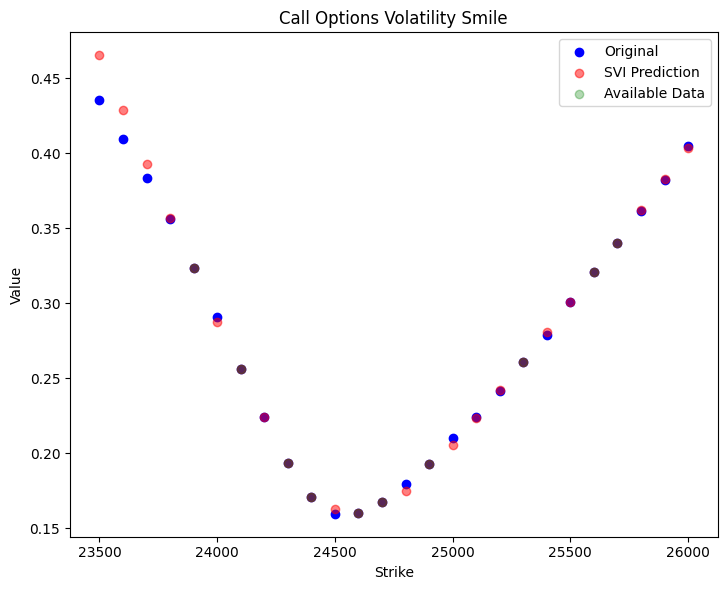

Fitting SVI models |████████████████████████████████████████| 39588/39588 [100%]|▏                                       | ▆▄▂ 166/39588 [0%]|▌                                       | ▆█▆ 503/39588 [1%]|█▊                                      | ▂▂▄ 1751/39588 [4%|██▋                                     | ▇▇▅ 2637/39588 [7%|█████▍                                  | ▅▃▁ 5339/39588 [13|████████▉                               | ▂▂▄ 8765/39588 [22|█████████▊                              | ▁▃▅ 9618/39588 [24|██████████▏                             | ▁▃▅ 9974/39588 [25|████████████                            | ▁▃▅ 11916/39588 [3|████████████▊                           | ▄▆█ 12598/39588 [3|██████████████▏                         | ▇▇▅ 14015/39588 [3|███████████████▊                        | ▁▃▅ 15624/39588 [3|████████████████▉                       | ▅▇▇ 16743/39588 [4|██████████████████████████████▏         | ▂▂▄ 29806/39588 [7|████████████████████████████████▏       | ▅▇▇ 31772/39588 [8|████

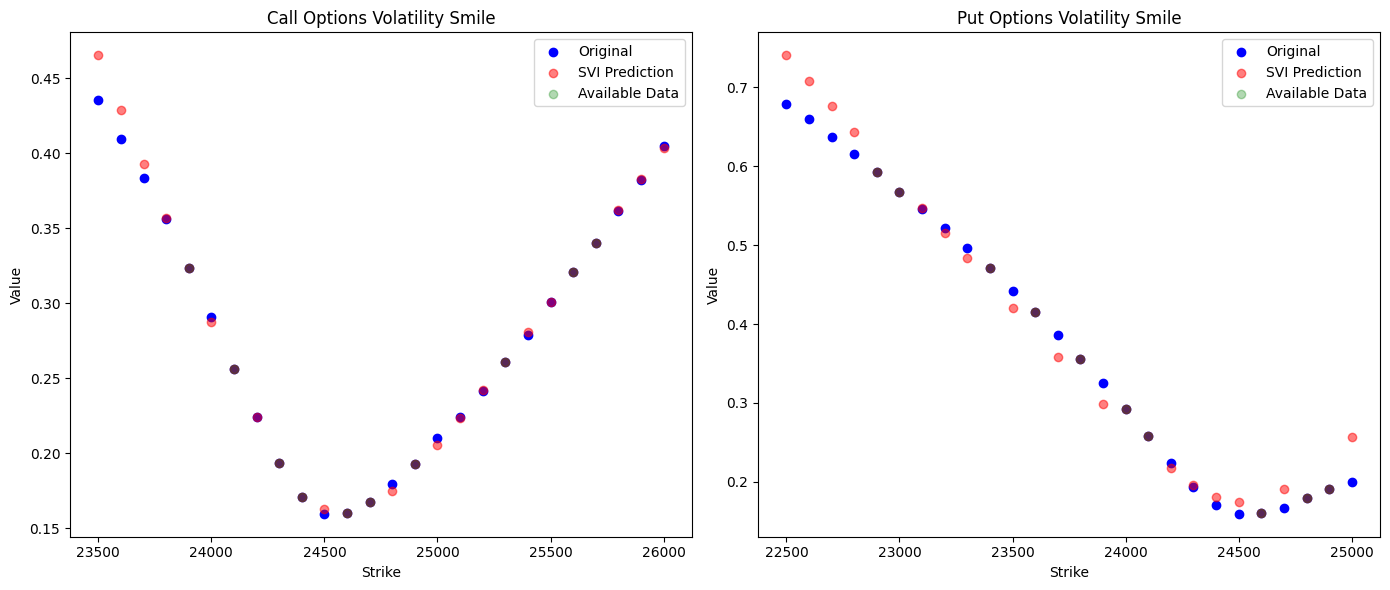

In [101]:
from scipy.optimize import minimize
import warnings

def fit_svi_and_predict(data, cols, moneyness_col='strike'):
    """
  Fit an SVI model to the non-NaN values in each row and predict missing values
  
  Parameters:
  data: DataFrame containing the data
  cols: List of columns to process (put or call columns)
  moneyness_col: Column name for strike prices
  
  Returns:
  DataFrame with NaN values filled using SVI interpolation
  """
    warnings.filterwarnings('ignore')
    cols = np.array(cols)
    result_data = data.copy()
    # Parse strike prices from column names if they're embedded in the column names
    strikes = np.array([float(col.split('_')[-1]) for col in cols])

    # SVI parameterization: v(k) = a + b * (rho * (k - m) + sqrt((k - m)^2 + sigma^2))
    def svi_model(k, params):
        a, b, rho, m, sigma = params
        return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

    # Error function for optimization
    def error_function(params, k, v):
        # TODO: MODIFY TO RMSE
        # return np.sum((svi_model(k, params) - v)**2)
        return rmse(svi_model(k, params), v)

    # Initial parameters [a, b, rho, m, sigma]
    initial_params = [0.032, 0.00022, -0.01, 24500, 300]
    bounds = [(-0.05, 0.3), (0.0001, 0.0004), (-0.6, 0.8), (24100, 26000), (100, 500)]
    with alive_bar(len(result_data), title="Fitting SVI models", bar='smooth', force_tty=True) as bar:
        for idx in result_data.index:
            # print("Fitting SVI for row:", idx)
            row_data = result_data.loc[idx, cols]

            # Get the available data points
            valid_mask = ~row_data.isna().values

            if sum(valid_mask) >= 5:  # Need at least 5 points for a good fit
                valid_strikes = strikes[valid_mask]
                valid_values = row_data.values[valid_mask]

                try:
                    # Fit the SVI model
                    result = minimize(
            error_function, 
            initial_params, 
            args=(valid_strikes, valid_values),
            bounds=bounds,
            method='L-BFGS-B'
            )

                    optimized_params = result.x

                    # Predict all points using the fitted model
                    all_predicted = svi_model(strikes, optimized_params)

                    # Fill in only the NaN values
                    nan_mask = row_data.isna()
                    result_data.loc[idx, cols[nan_mask]] = all_predicted[nan_mask]

                except Exception as e:
                    print(f"Error fitting SVI for row {idx}: {e}")
                    continue
            else:
                print(f"Not enough valid data points for row {idx}, skipping SVI fit.")
            bar()
    return result_data

# Use the function to predict missing values for call and put options separately
call_cols = [col for col in pred_cols if col.startswith('call')]
put_cols = [col for col in pred_cols if col.startswith('put')]

# Extract strikes from column names
call_strikes = np.array([float(col.split('_')[-1]) for col in call_cols])
put_strikes = np.array([float(col.split('_')[-1]) for col in put_cols])


def draw_plot(plot_idx, index_type=["call"]):
    plt.figure(figsize=(14, 6))
    if "call" in index_type:
        plt.subplot(1, 2, 1)
        plt.scatter(
            call_strikes, val_Y.loc[plot_idx, call_cols], color="blue", label="Original"
        )
        plt.scatter(
            call_strikes,
            filled_val_data.loc[plot_idx, call_cols],
            color="red",
            alpha=0.5,
            label="SVI Prediction",
        )
        plt.scatter(
            call_strikes,
            sample_val.loc[plot_idx, call_cols],
            color="green",
            alpha=0.3,
            label="Available Data",
        )
        plt.title("Call Options Volatility Smile")
        plt.xlabel("Strike")
        plt.ylabel("Value")
        plt.legend()
    if "put" in index_type:
        # Plot puts
        plt.subplot(1, 2, 2)
        plt.scatter(
            put_strikes, val_Y.loc[plot_idx, put_cols], color="blue", label="Original"
        )
        plt.scatter(
            put_strikes,
            filled_val_data.loc[plot_idx, put_cols],
            color="red",
            alpha=0.5,
            label="SVI Prediction",
        )
        plt.scatter(
            put_strikes,
            sample_val.loc[plot_idx, put_cols],
            color="green",
            alpha=0.3,
            label="Available Data",
        )
        plt.title("Put Options Volatility Smile")
        plt.xlabel("Strike")
        plt.ylabel("Value")
        plt.legend()

    plt.tight_layout()
    plt.show()


# Fill in missing values using SVI
filled_val_data = sample_val.copy()
filled_val_data = fit_svi_and_predict(filled_val_data, call_cols)
sample_idx = filled_val_data.index[0]
draw_plot(sample_idx, index_type=["call"])
filled_val_data = fit_svi_and_predict(filled_val_data, put_cols)

# Calculate RMSE between original and filled values
filled_rmse = rmse(val_Y[pred_cols].values.flatten(), 
          filled_val_data[pred_cols].values.flatten())
print(f"RMSE after SVI filling: {filled_rmse:.6f}")

# Plot an example row to visualize the SVI fit

draw_plot(sample_idx, index_type=['call', 'put'])

In [57]:
final_pred_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"),
        test_data.columns.tolist(),
    )
)
len(final_pred_cols)

52

In [58]:
# Use the function to predict missing values for call and put options separately
call_cols = [col for col in final_pred_cols if col.startswith("call")]
put_cols = [col for col in final_pred_cols if col.startswith("put")]

# Extract strikes from column names
call_strikes = np.array([float(col.split("_")[-1]) for col in call_cols])
put_strikes = np.array([float(col.split("_")[-1]) for col in put_cols])

filled_val_data = test_data.copy()
filled_val_data = fit_svi_and_predict(filled_val_data, call_cols)
filled_val_data = fit_svi_and_predict(filled_val_data, put_cols)

on 18: Not enough valid data points for row 18, skipping SVI fit.               
on 92: Not enough valid data points for row 92, skipping SVI fit.               
on 343: Not enough valid data points for row 343, skipping SVI fit.             
on 518: Not enough valid data points for row 518, skipping SVI fit.             
on 663: Not enough valid data points for row 663, skipping SVI fit.             
on 843: Not enough valid data points for row 843, skipping SVI fit.             
on 852: Not enough valid data points for row 852, skipping SVI fit.             
on 1042: Not enough valid data points for row 1042, skipping SVI fit.           
on 1384: Not enough valid data points for row 1384, skipping SVI fit.           |████                                    | ▆█▆ 1200/12065 [10
on 1485: Not enough valid data points for row 1485, skipping SVI fit.           
on 1612: Not enough valid data points for row 1612, skipping SVI fit.           |█████▏                                  | ▅▃▁ 15

In [43]:
filled_val_data

,timestamp,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,0,24735.9,0.280939,0.270276,0.250193,0.232541,0.242149,0.210755,0.232439,0.213457,...,0.006587,0.002826,-1.737617e+05,-0.009541,-0.017831,0.000264,2.032521e+06,1.000000e-06,-0.077238,-5.362742e+06
1,1,24766.7,0.270276,0.228516,0.258893,0.206518,0.199473,0.196802,0.233548,0.205938,...,0.005777,0.004588,-3.195086e+05,-0.024106,-0.004696,-0.000158,-4.529075e+06,-1.619022e+06,-0.956928,4.624907e+06
2,2,24896.9,0.284080,0.251731,0.236254,0.215243,0.214869,0.204580,0.194604,0.178287,...,0.000829,-0.034944,1.027525e+06,0.028201,0.032234,0.007687,2.663908e+06,0.000000e+00,-0.116264,-2.669766e+06
3,3,24898.1,0.241888,0.234282,0.220505,0.195540,0.198602,0.186190,0.165814,0.166083,...,-0.009323,-0.022969,-4.720074e+06,-0.001513,0.008704,-0.000206,-7.672936e+06,-1.903406e+06,-2.249208,-1.858254e+07
4,4,24906.5,0.235328,0.222960,0.222983,0.214126,0.180297,0.171832,0.192603,0.166790,...,-0.018674,-0.007588,-4.051681e+05,-0.136267,0.002425,-0.002200,1.334469e+06,2.548789e+05,1.999104,3.024212e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060,12060,24992.1,0.230661,0.233427,0.202447,0.190051,0.179769,0.172550,0.168868,0.186856,...,-0.010750,0.006911,-1.497117e+05,-0.059785,-0.014518,-0.006756,-7.822864e+06,2.149933e+05,-2.069687,-6.738094e+06
12061,12061,25020.3,0.229413,0.236380,0.226972,0.192159,0.182726,0.200906,0.193655,0.172159,...,-0.000224,0.024468,-1.176289e+06,-0.016344,-0.034368,0.001133,-2.392407e+06,-1.176289e+06,-2.023157,6.031379e+03
12062,12062,24897.2,0.256475,0.243817,0.234267,0.221270,0.189260,0.178073,0.172575,0.185088,...,-0.009009,0.006057,1.920387e+06,-0.016521,-0.013230,-0.009278,2.287786e+06,0.000000e+00,1.751653,-3.621450e+06
12063,12063,25035.6,0.226728,0.239825,0.200845,0.189474,0.180041,0.173418,0.170041,0.190833,...,0.001625,0.063421,6.357844e+05,0.077753,0.068983,0.000112,8.723009e+06,2.352188e+05,1.502687,-1.177899e+06


In [59]:
filled_val_data.isna().sum().sum()

3498

In [60]:
test_data = filled_val_data.copy()
test_pred_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"),
        test_data.columns.tolist(),
    )
)

# Extract strike prices from column names
call_strike_prices = np.array(
    [float(col.split("_")[-1]) for col in test_pred_cols if col.startswith("call")]
)
put_strike_prices = np.array(
    [float(col.split("_")[-1]) for col in test_pred_cols if col.startswith("put")]
)

# Initialize dataframe to store predictions
preds = pd.DataFrame(index=test_data.index, columns=test_pred_cols)


# Function to perform quadratic regression for a single row
def quad_regression_predict(row, strike_prices, option_type):
    # Get column names for this option type
    cols = [col for col in test_pred_cols if col.startswith(option_type)]

    # Get non-NaN values and their corresponding strike prices
    valid_mask = ~row[cols].isna()
    valid_cols = np.array(cols)[valid_mask]

    if len(valid_cols) < 3:  # Need at least 3 points for quadratic regression
        print("<3 valid cols for", option_type, "at row", row.name)
        return None

    y_vals = row[valid_cols].values.astype(np.float64)
    x_vals = np.array([float(col.split("_")[-1]) for col in valid_cols])
    # Perform quadratic regression
    coeffs = np.polyfit(x_vals, y_vals, 2)
    poly = np.poly1d(coeffs)

    # Predict for all strike prices of this option type
    all_strikes = strike_prices
    predictions = pd.Series(
        poly(all_strikes),
        index=[f"{option_type}_iv_{int(strike)}" for strike in all_strikes],
    )
    predictions[valid_cols] = row[valid_cols].astype(
        np.float64
    )  # Keep original values for known strikes
    return predictions


# Apply regression for each row
for idx in test_data.index:
    # Process call options
    call_predictions = quad_regression_predict(
        test_data.loc[idx], call_strike_prices, "call"
    )
    if call_predictions is not None:
        preds.loc[idx, call_predictions.index] = call_predictions

    # Process put options
    put_predictions = quad_regression_predict(
        test_data.loc[idx], put_strike_prices, "put"
    )
    if put_predictions is not None:
        preds.loc[idx, put_predictions.index] = put_predictions

# Fill in any missing values using original values (if any regression failed)
for col in test_pred_cols:
    nan_mask = preds[col].isna()
    if nan_mask.any():
        preds.loc[nan_mask, col] = test_data.loc[nan_mask, col]
test_data[preds.columns] = preds
test_data

<3 valid cols for call at row 6278
<3 valid cols for put at row 8186
<3 valid cols for put at row 8365
<3 valid cols for put at row 9086
<3 valid cols for put at row 9171


,timestamp,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,0,24735.9,0.280939,0.270276,0.250193,0.232541,0.242149,0.210755,0.232439,0.213457,...,0.006587,0.002826,-1.737617e+05,-0.009541,-0.017831,0.000264,2.032521e+06,1.000000e-06,-0.077238,-5.362742e+06
1,1,24766.7,0.270276,0.228516,0.258893,0.206518,0.199473,0.196802,0.233548,0.205938,...,0.005777,0.004588,-3.195086e+05,-0.024106,-0.004696,-0.000158,-4.529075e+06,-1.619022e+06,-0.956928,4.624907e+06
2,2,24896.9,0.28408,0.251731,0.236254,0.215243,0.214869,0.20458,0.194604,0.178287,...,0.000829,-0.034944,1.027525e+06,0.028201,0.032234,0.007687,2.663908e+06,0.000000e+00,-0.116264,-2.669766e+06
3,3,24898.1,0.241888,0.234282,0.220505,0.19554,0.198602,0.18619,0.165814,0.166083,...,-0.009323,-0.022969,-4.720074e+06,-0.001513,0.008704,-0.000206,-7.672936e+06,-1.903406e+06,-2.249208,-1.858254e+07
4,4,24906.5,0.235328,0.22296,0.222983,0.214126,0.180297,0.171832,0.192603,0.16679,...,-0.018674,-0.007588,-4.051681e+05,-0.136267,0.002425,-0.002200,1.334469e+06,2.548789e+05,1.999104,3.024212e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060,12060,24992.1,0.230661,0.233427,0.202447,0.190051,0.179769,0.17255,0.168868,0.186856,...,-0.010750,0.006911,-1.497117e+05,-0.059785,-0.014518,-0.006756,-7.822864e+06,2.149933e+05,-2.069687,-6.738094e+06
12061,12061,25020.3,0.229413,0.23638,0.226972,0.192159,0.182726,0.200906,0.193655,0.172159,...,-0.000224,0.024468,-1.176289e+06,-0.016344,-0.034368,0.001133,-2.392407e+06,-1.176289e+06,-2.023157,6.031379e+03
12062,12062,24897.2,0.256475,0.243817,0.234267,0.22127,0.18926,0.178073,0.172575,0.185088,...,-0.009009,0.006057,1.920387e+06,-0.016521,-0.013230,-0.009278,2.287786e+06,0.000000e+00,1.751653,-3.621450e+06
12063,12063,25035.6,0.226728,0.239825,0.200845,0.189474,0.180041,0.173418,0.170041,0.190833,...,0.001625,0.063421,6.357844e+05,0.077753,0.068983,0.000112,8.723009e+06,2.352188e+05,1.502687,-1.177899e+06


In [61]:
test_data.isna().sum().sum()

122

In [62]:
filled_val_data = test_data.copy()

In [64]:
# filling remaining 122 nan values (< 3 valid cols)
for col in final_pred_cols:
    test_df_col = filled_val_data[col].copy()
    test_df_col.dropna(inplace=True)
    median = test_df_col.median()
    # print(median)
    filled_val_data[col] = filled_val_data[col].fillna(median)
filled_val_data.isna().sum().sum()

0

In [65]:
svi_submission = filled_val_data[submission_cols]
svi_submission.to_csv(f"{output_path}/svi_submission.csv", index=False)
svi_submission

,timestamp,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,0,0.280939,0.270276,0.250193,0.232541,0.242149,0.210755,0.232439,0.213457,0.222997,...,0.232334,0.209462,0.219982,0.227301,0.234169,0.260675,0.250422,0.290968,0.306525,0.282229
1,1,0.270276,0.228516,0.258893,0.206518,0.199473,0.196802,0.233548,0.205938,0.215711,...,0.176348,0.228209,0.185828,0.194696,0.204963,0.249402,0.227833,0.239949,0.252343,0.264938
2,2,0.284080,0.251731,0.236254,0.215243,0.214869,0.204580,0.194604,0.178287,0.180820,...,0.194612,0.188052,0.180620,0.183538,0.181346,0.191510,0.190750,0.200892,0.205859,0.210943
3,3,0.241888,0.234282,0.220505,0.195540,0.198602,0.186190,0.165814,0.166083,0.169689,...,0.166511,0.166394,0.161561,0.191283,0.202948,0.172032,0.228196,0.241379,0.254790,0.206107
4,4,0.235328,0.222960,0.222983,0.214126,0.180297,0.171832,0.192603,0.166790,0.168542,...,0.174040,0.173473,0.174844,0.177920,0.180727,0.176000,0.188575,0.192857,0.182314,0.201821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060,12060,0.230661,0.233427,0.202447,0.190051,0.179769,0.172550,0.168868,0.186856,0.169744,...,0.176763,0.176237,0.177648,0.177270,0.183612,0.187425,0.176356,0.177716,0.200333,0.204908
12061,12061,0.229413,0.236380,0.226972,0.192159,0.182726,0.200906,0.193655,0.172159,0.173530,...,0.192996,0.187448,0.183143,0.180196,0.177969,0.177923,0.178373,0.180254,0.183455,0.187863
12062,12062,0.256475,0.243817,0.234267,0.221270,0.189260,0.178073,0.172575,0.185088,0.179760,...,0.192306,0.178946,0.179666,0.176916,0.186976,0.191153,0.195665,0.200406,0.201360,0.209940
12063,12063,0.226728,0.239825,0.200845,0.189474,0.180041,0.173418,0.170041,0.190833,0.185851,...,0.177085,0.190933,0.186172,0.180508,0.183862,0.187686,0.191817,0.178806,0.200646,0.205242


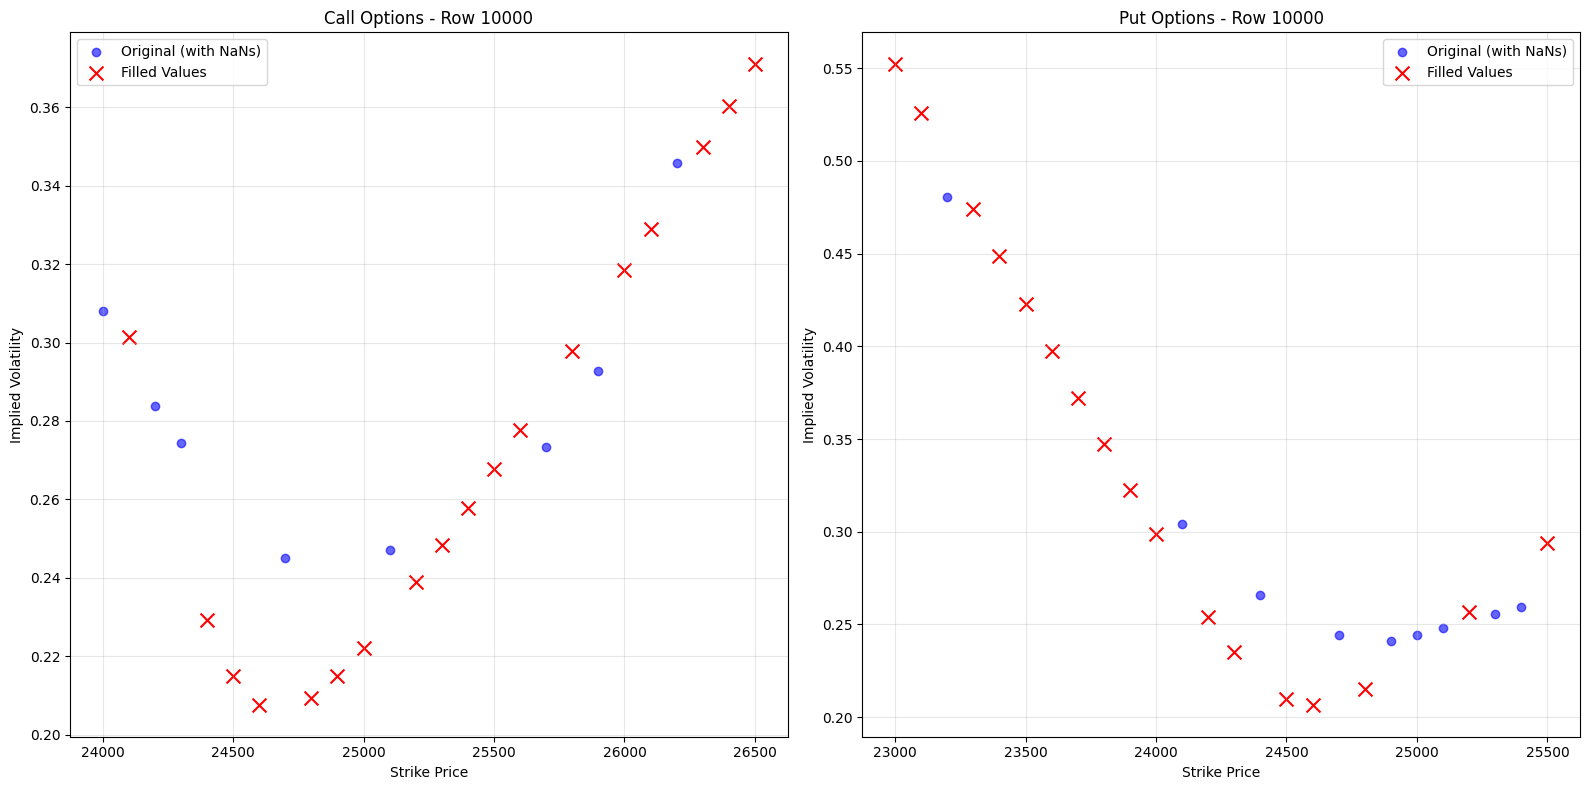

In [84]:
# Load test data into another variable for comparison
original_test_data = pd.read_parquet("data/test_data.parquet")

def compare_predictions(row_idx, data_type=["call", "put"]):
  """
  Draw a graph comparing original test data with filled data for a specific row
  
  Parameters:
  row_idx (int): The index of the row to plot
  data_type (list): Types of options to plot - "call", "put", or both
  """
  plt.figure(figsize=(16, 8))
  
  if "call" in data_type:
    call_cols = [col for col in final_pred_cols if col.startswith('call')]
    call_strikes = np.array([float(col.split("_")[-1]) for col in call_cols])
    
    plt.subplot(1, 2, 1)
    # Original data with NaNs
    plt.scatter(call_strikes, original_test_data.loc[row_idx, call_cols], 
           color="blue", label="Original (with NaNs)", alpha=0.6)
    
    # Plot NaN points differently
    nan_mask = original_test_data.loc[row_idx, call_cols].isna()
    plt.scatter(call_strikes[nan_mask], 
           filled_val_data.loc[row_idx, call_cols].values[nan_mask], 
           color="red", marker="x", s=100, label="Filled Values")
    
    plt.title("Call Options - Row {}".format(row_idx))
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.grid(True, alpha=0.3)
  
  if "put" in data_type:
    put_cols = [col for col in final_pred_cols if col.startswith('put')]
    put_strikes = np.array([float(col.split("_")[-1]) for col in put_cols])
    
    plt.subplot(1, 2, 2)
    # Original data with NaNs
    plt.scatter(put_strikes, original_test_data.loc[row_idx, put_cols], 
           color="blue", label="Original (with NaNs)", alpha=0.6)
    
    # Plot NaN points differently
    nan_mask = original_test_data.loc[row_idx, put_cols].isna()
    plt.scatter(put_strikes[nan_mask], 
           filled_val_data.loc[row_idx, put_cols].values[nan_mask], 
           color="red", marker="x", s=100, label="Filled Values")
    
    plt.title("Put Options - Row {}".format(row_idx))
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.grid(True, alpha=0.3)
  
  plt.tight_layout()
  plt.show()

# Find a row with some NaN values to demonstrate

compare_predictions(10000)